In [1]:
# import dataset, model and layers  
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt
from scipy import misc
from __future__ import print_function
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
#import splitfolders
from keras import Model
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import img_to_array, load_img
from keras.layers import ZeroPadding2D
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D,Dropout, Flatten, BatchNormalization, Concatenate, AveragePooling2D
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.layers.normalization import BatchNormalization

## load the libraries 
import sys
import warnings
import os
import glob
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split

from keras.layers import *
from keras.callbacks import EarlyStopping
#from keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.metrics import *
from keras.optimizers import Adam, RMSprop
from scipy.stats import norm
from keras.preprocessing import image
from keras import datasets

from keras import backend as K

from imgaug import augmenters
import matplotlib.pyplot as plt
plt.gray()

<Figure size 432x288 with 0 Axes>

In [2]:
#Get access to google drive directory
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Function to load image and convert into array
def convert_img_to_array(dir_path):
    x = []
    #y = []
    one_hot_lookups = np.eye(15)
    i = 0
    for category in sorted(os.listdir(dir_path)):
      #for file in os.listdir(dir_path + category):
       #     img = load_img(dir_path + category + '/' + file,
        #               target_size=(64, 64))  # Load image
      while i<=140:
        for file in os.listdir(dir_path):
          img = load_img(dir_path + file,
                    target_size=(258,540))  # Load image
          img = img_to_array(img)  # Convert image to array
          img = preprocess_input(img)  # Preprocessing on the image
          x.append(img)  # Append image to X_train
          i+=1
            #y.append(np.reshape(one_hot_lookups[int(category)],
             #                     [15]))  # Append category to y_train
    #return x,y
    return x


In [4]:
#Function to load image data
def load_data():
    train_dir_path = "/content/drive/My Drive/DDD/train/"
    x_train = convert_img_to_array(train_dir_path)
    test_dir_path = "/content/drive/My Drive/DDD/test/"
    x_test = convert_img_to_array(test_dir_path)
    train_cleaned_dir_path = "/content/drive/My Drive/DDD/train_cleaned/"
    x_train_cleaned = convert_img_to_array(train_cleaned_dir_path)
    
    x_train = np.asarray(x_train)
    x_test = np.asarray(x_test)
    x_train_cleaned = np.asarray(x_train_cleaned)
    x_train = x_train/255.
    x_test = x_test/255.
    x_train_cleaned = x_train_cleaned/255.

    return x_test, x_train, x_train_cleaned

x_train,x_test, x_train_cleaned = load_data()

In [5]:
#f, ax = plt.subplots(1,5)
#f.set_size_inches(260,540)
#for i in range(5,10):
#    ax[i-5].imshow(x_train[i, :, :, 0].reshape(260,540))

In [6]:
#f, ax = plt.subplots(1,5)
#f.set_size_inches(260,540)
#for i in range(5,10):
#    ax[i-5].imshow(x_test[i, :, :, 0].reshape(260,540))

In [7]:
#f, ax = plt.subplots(1,5)
#f.set_size_inches(260,540)
#for i in range(5,10):
#    ax[i-5].imshow(x_train_cleaned[i, :, :, 0].reshape(260,540))

In [8]:
x_train.shape

In [9]:
x_test.shape

In [10]:
x_train_cleaned.shape

In [11]:
noise = augmenters.SaltAndPepper(0.1)
seq_object = augmenters.Sequential([noise])

train_x_n = seq_object.augment_images(x_train_cleaned * 255) / 255

In [12]:
# input layer
input_layer = Input(shape=(258, 540,1))

# encoding architecture
encoded_layer1 = Conv2D(128, (3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = MaxPool2D( (2, 2), padding='same')(encoded_layer1)
encoded_layer2 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = MaxPool2D( (2, 2), padding='same')(encoded_layer2)
encoded_layer3 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer2)
latent_view    = MaxPool2D( (2, 2), padding='same')(encoded_layer3)

In [13]:
# decoding architecture
decoded_layer1 = Conv2D(32, (3, 3), activation='relu', padding='same')(latent_view)
decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)
decoded_layer2 = Conv2D(64, (3, 3), activation='relu', padding='same')(decoded_layer1)
decoded_layer2 = UpSampling2D((2, 2))(decoded_layer2)
decoded_layer3 = Conv2D(128, (3, 3), activation='relu')(decoded_layer2)
decoded_layer3 = UpSampling2D((2, 2))(decoded_layer3)
output_layer   = Conv2D(1, (3, 3), padding='same')(decoded_layer3)

In [14]:
# compile the model
model = Model(input_layer, output_layer)
model.compile(optimizer='adam', loss='mse')

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 260, 540, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 260, 540, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 130, 270, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 130, 270, 64)      73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 65, 135, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 65, 135, 32)       18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 33, 68, 32)        0     

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='auto')
history = model.fit(train_x_n, x_train_cleaned, epochs=25, batch_size=16, validation_data=(x_test, x_train_cleaned), callbacks=[early_stopping])

Epoch 1/25
9/9 [==============================] - 52s 554ms/step - loss: 0.1712 - val_loss: 0.0779
Epoch 2/25
9/9 [==============================] - 4s 485ms/step - loss: 0.0819 - val_loss: 0.0870
Epoch 3/25
9/9 [==============================] - 4s 488ms/step - loss: 0.0682 - val_loss: 0.0756
Epoch 4/25
9/9 [==============================] - 4s 490ms/step - loss: 0.0612 - val_loss: 0.0794
Epoch 5/25
9/9 [==============================] - 4s 495ms/step - loss: 0.0583 - val_loss: 0.0863
Epoch 6/25
9/9 [==============================] - 4s 511ms/step - loss: 0.0571 - val_loss: 0.0809
Epoch 7/25
9/9 [==============================] - 4s 501ms/step - loss: 0.0556 - val_loss: 0.0818
Epoch 8/25
9/9 [==============================] - 4s 514ms/step - loss: 0.0541 - val_loss: 0.0812
Epoch 9/25
9/9 [==============================] - 5s 520ms/step - loss: 0.0552 - val_loss: 0.0890
Epoch 10/25
9/9 [==============================] - 4s 516ms/step - loss: 0.0555 - val_loss: 0.0793
Epoch 11/25
9/9 [=

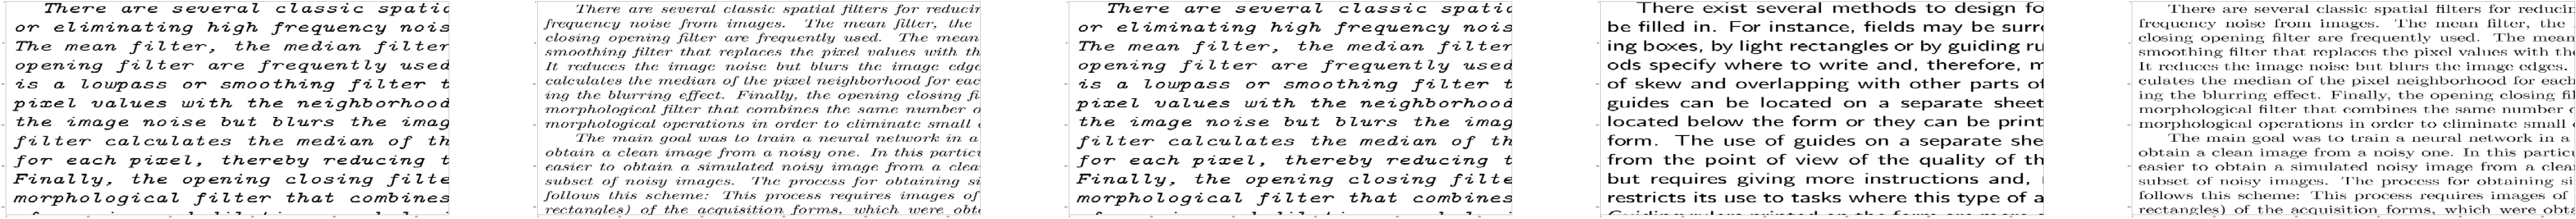

In [17]:
n = np.random.randint(0,len(x_train_cleaned)-5)

f, ax = plt.subplots(1,5)
f.set_size_inches(258,540)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(x_train_cleaned[a, :, :, 0].reshape(258,540))

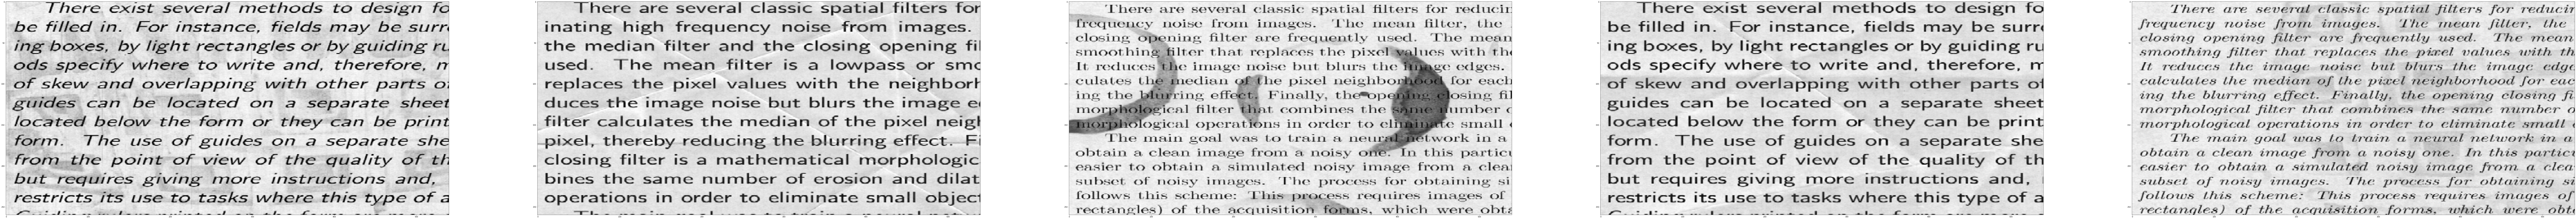

In [18]:
f, ax = plt.subplots(1,5)
f.set_size_inches(258,540)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(x_test[a, :, :, 0].reshape(258,540))

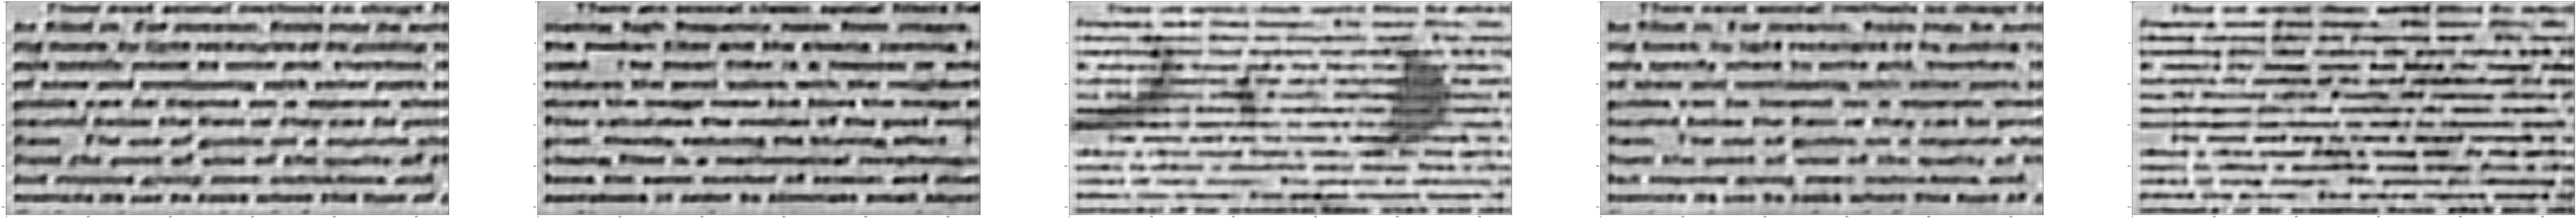

In [19]:
preds = model.predict(x_test[n:n+5])
f, ax = plt.subplots(1,5)
f.set_size_inches(258,540)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(preds[i].reshape(258,540))
plt.show()

In [20]:
import math
import numpy as np

def calculate_psnr(img1, img2):
    # img1 and img2 have range [0, 255]
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))
    
calculate_psnr(x_test[0], preds[0])

59.90036440211089

In [24]:
# compile the model
model_2 = Model(input_layer, latent_view)
model_2.compile(optimizer='adam', loss='mse')

In [25]:
preds = model_2.predict(x_test[n:n+5])
preds.shape

(5, 33, 68, 32)

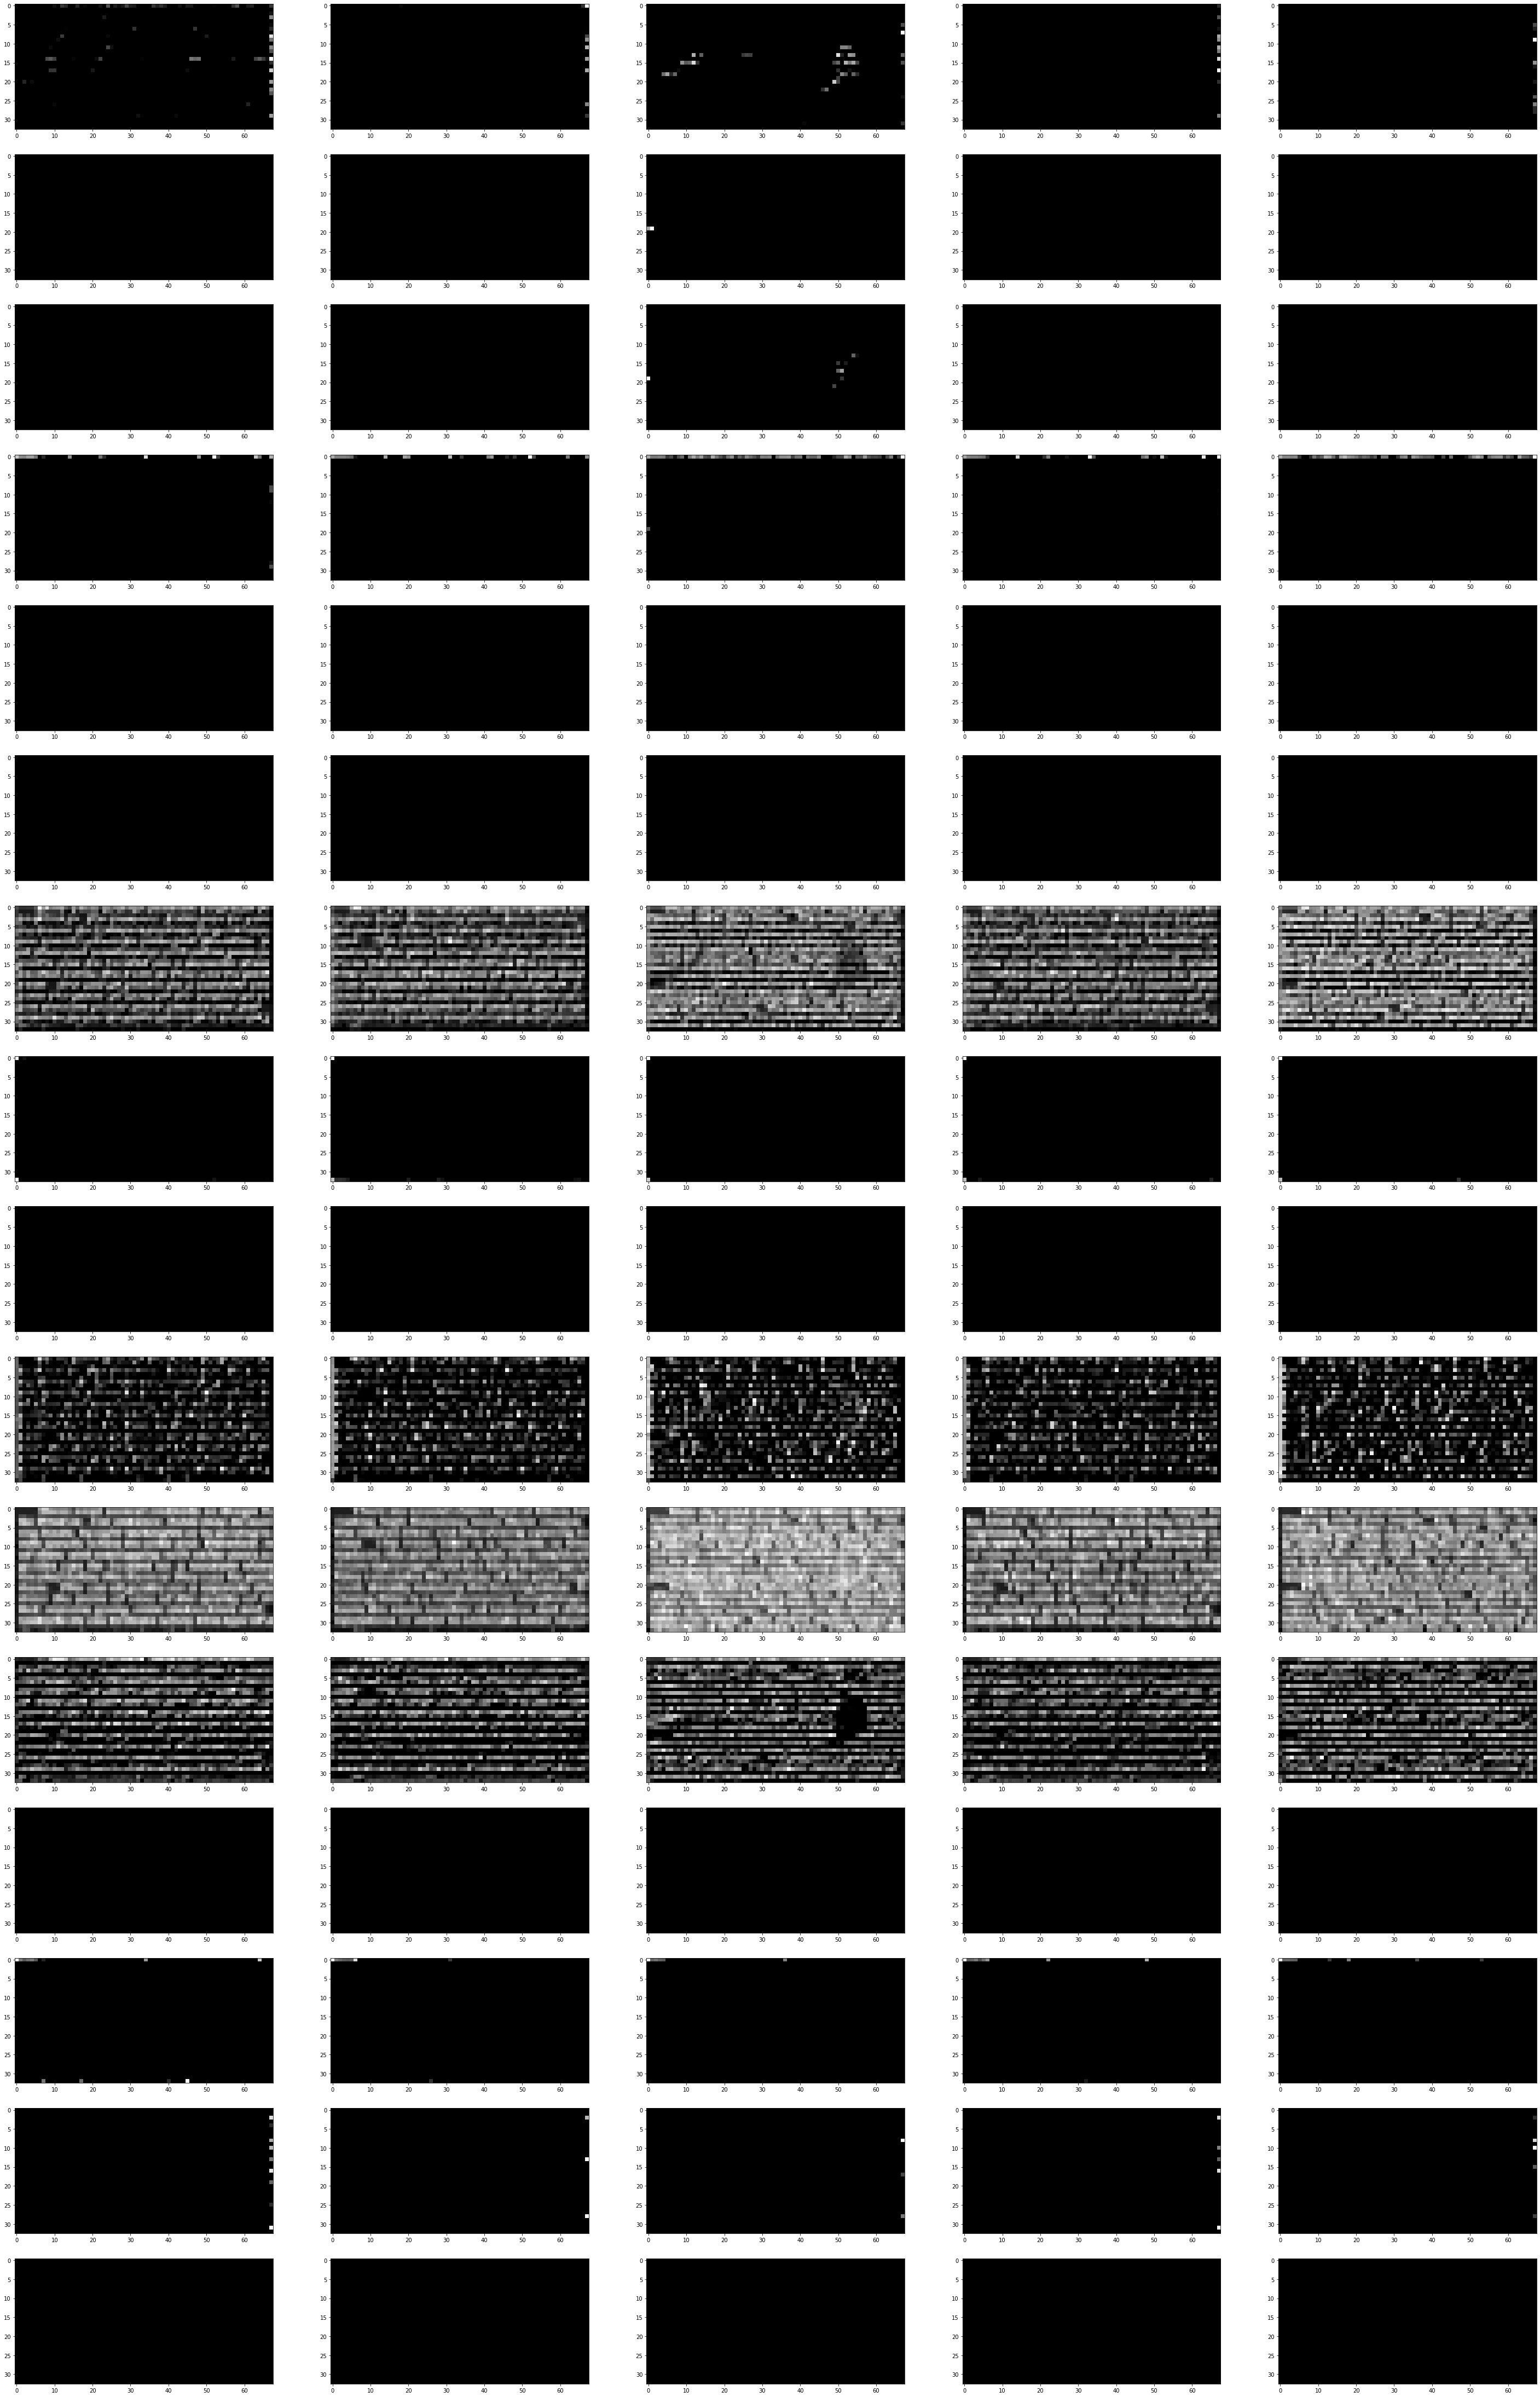

In [26]:
f, ax = plt.subplots(16,5)
ax = ax.ravel()
f.set_size_inches(50, 80)
for j in range(16):
    for i,a in enumerate(range(n,n+5)):
        ax[j*5 + i].imshow(preds[i, :, :, j])
plt.show()